## Module Import & Data Load

In [1]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr
from src import dataset

import pickle
from torchinfo import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

In [6]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [196]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [12]:
train_shape = next(iter(trainloader))['given'].shape
print(train_shape)

torch.Size([64, 89, 86])


In [147]:
TRAIN_DATASET = sorted([x for x in Path("HAICon2021_dataset/train/").glob("*.csv")])
TRAIN_DATASET

[PosixPath('HAICon2021_dataset/train/train1.csv'),
 PosixPath('HAICon2021_dataset/train/train2.csv'),
 PosixPath('HAICon2021_dataset/train/train3.csv'),
 PosixPath('HAICon2021_dataset/train/train4.csv'),
 PosixPath('HAICon2021_dataset/train/train5.csv'),
 PosixPath('HAICon2021_dataset/train/train6.csv')]

In [148]:
TEST_DATASET = sorted([x for x in Path("HAICon2021_dataset/test/").glob("*.csv")])
TEST_DATASET

[PosixPath('HAICon2021_dataset/test/test1.csv'),
 PosixPath('HAICon2021_dataset/test/test2.csv'),
 PosixPath('HAICon2021_dataset/test/test3.csv')]

In [149]:
VALIDATION_DATASET = sorted([x for x in Path("HAICon2021_dataset/validation/").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('HAICon2021_dataset/validation/validation.csv')]

In [150]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [151]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,2021-08-09 08:59:56,-2.0065,0,12.26196,0.00051,100.28228,0.5977,12.53358,70,1,...,1.17355,35.05434,10.00000,3178.48877,370.02679,1,986.05908,12.0,50,136
259196,2021-08-09 08:59:57,-2.2101,0,12.26196,-0.00029,100.28228,0.5509,12.53358,70,1,...,1.16898,35.03488,10.00000,3175.36084,370.40656,1,986.05908,12.0,50,89
259197,2021-08-09 08:59:58,-2.3325,0,12.26196,0.00152,100.28228,0.5425,12.53358,70,1,...,1.16974,35.02840,10.00000,3175.73608,368.12787,1,986.05908,12.0,50,90
259198,2021-08-09 08:59:59,-2.3049,0,12.26196,0.00058,100.26703,0.6266,12.53358,70,1,...,1.16974,35.02420,10.00000,3176.61182,368.01941,1,986.05908,12.0,50,74


In [152]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

In [153]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [154]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [155]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,...,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.395098,0.0,0.056338,0.517560,0.121738,0.397053,0.816071,0.0,0.0,0.0,...,0.240561,0.194535,0.708818,0.165517,0.168332,0.0,0.538147,0.0,0.0,0.275176
2,0.333267,0.0,0.056338,0.504886,0.139408,0.405431,0.816071,0.0,0.0,0.0,...,0.238319,0.195226,0.708818,0.141083,0.180570,0.0,0.538147,0.0,0.0,0.274889
3,0.446345,0.0,0.056338,0.522383,0.154058,0.436703,0.816071,0.0,0.0,0.0,...,0.236754,0.196440,0.708818,0.125447,0.187292,0.0,0.538147,0.0,0.0,0.277264
4,0.328324,0.0,0.056338,0.517845,0.157091,0.439827,0.816071,0.0,0.0,0.0,...,0.237495,0.196492,0.708818,0.117700,0.187419,0.0,0.538147,0.0,0.0,0.275990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,0.485034,0.0,0.056340,0.515751,0.994085,0.520004,0.640361,0.0,0.0,0.0,...,0.403941,0.696846,1.000000,0.996289,0.517805,0.0,0.414192,0.0,0.0,0.018717
259196,0.447224,0.0,0.056338,0.509379,0.994085,0.510481,0.640361,0.0,0.0,0.0,...,0.401381,0.695028,1.000000,0.995484,0.518674,0.0,0.414192,0.0,0.0,0.015676
259197,0.423251,0.0,0.056338,0.528358,0.994085,0.508101,0.640361,0.0,0.0,0.0,...,0.401571,0.694256,1.000000,0.995510,0.511131,0.0,0.414192,0.0,0.0,0.015440
259198,0.425407,0.0,0.056338,0.520068,0.993949,0.522157,0.640361,0.0,0.0,0.0,...,0.401590,0.693797,1.000000,0.995761,0.510014,0.0,0.414192,0.0,0.0,0.014318


In [156]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=10)
HAI_DATASET_TRAIN[0]


# of valid windows: 100387


{'ts': '2021-07-11 10:01:29',
 'given': tensor([[0.4331, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2761],
         [0.3951, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2752],
         [0.3333, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2749],
         ...,
         [0.3205, 0.0000, 0.0548,  ..., 0.0000, 0.0000, 0.0091],
         [0.4451, 0.0000, 0.0562,  ..., 0.0000, 0.0000, 0.0091],
         [0.3477, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.0091]]),
 'answer': tensor([0.3711, 0.0000, 0.0563, 0.5032, 0.1387, 0.4298, 0.8161, 0.0000, 0.0000,
         0.0000, 0.7223, 0.6224, 0.4866, 0.4075, 0.2524, 0.2907, 0.0000, 0.0000,
         0.0000, 0.3050, 0.4108, 0.0000, 0.3492, 0.6516, 0.0120, 0.0000, 0.3563,
         0.3370, 0.0000, 0.9763, 0.5501, 0.3796, 0.3818, 0.0000, 0.9009, 0.0000,
         0.2097, 0.0000, 0.0000, 0.0249, 0.2642, 0.5416, 0.5994, 0.4009, 0.0021,
         1.0000, 0.5253, 1.0000, 0.0000, 0.2244, 0.4755, 0.0000, 0.4874, 0.0509,
         0.0000, 0.3105, 0.7985, 0.1781, 0.2572, 0.4340, 1.

In [157]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,...,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,...,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,...,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,...,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,...,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,...,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,...,31.79738,0.716042,1179.76929,348.03607,1,1018.394040,12.0,50,7,0
86397,2021-07-10 23:59:58,-2.3564,0,12.26196,-0.00101,15.53497,0.2907,12.669310,70,1,...,31.78784,0.716042,1152.66187,348.81366,1,1018.394040,12.0,50,7,0
86398,2021-07-10 23:59:59,-2.1541,0,12.26196,-0.00166,15.53497,0.3280,12.669310,70,1,...,31.77029,0.716042,1130.65723,349.13916,1,1018.394040,12.0,50,7,0


In [158]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [159]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 86311


{'attack': 0.0,
 'ts': '2021-07-10 00:01:30',
 'given': tensor([[ 0.4743,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0208],
         [ 0.4495,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0204],
         [ 0.3742,  0.0000, -0.0423,  ...,  0.0000,  0.0000,  0.0199],
         ...,
         [ 0.4637,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4637,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4752,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090]]),
 'answer': tensor([ 3.2394e-01,  0.0000e+00, -4.0688e-02,  5.5395e-01,  1.4765e-01,
          4.0518e-01,  1.1192e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.0476e-01,  5.4933e-01,  4.3357e-01,  5.1551e-01,  3.9176e-01,
          2.2724e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.4392e-01,
          5.1435e-01,  0.0000e+00,  4.3408e-01,  2.6753e-01,  1.0705e-01,
          0.0000e+00,  4.3857e-01,  3.6767e-01,  0.0000e+00,  9.9556e-01,
          5.8638e-01,  2.9160e-01,  2.1829e-01,  

In [162]:
boundary_check(VALIDATION_DF)

(True, True, False)

In [163]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 4,
          'pin_memory' : True}
trainloader = DataLoader(HAI_DATASET_TRAIN, **params)
params['shuffle'] = False
validloader = DataLoader(HAI_DATASET_VALIDATION, **params)
testloader = DataLoader(HAI_DATASET_TEST, **params)

## Model

In [60]:
class anomaly_detecter(nn.Module):
    def __init__(self, input_channel, kernel_size=7, stride=2):
        super(anomaly_detecter, self).__init__()
        
        self.ad_layer = nn.Sequential(
            nn.Conv1d(input_channel, 32, kernel_size, stride=stride, padding=3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(32, 16, kernel_size, stride=stride, padding=3),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 16, kernel_size, stride=stride, padding=3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(16, 32, kernel_size, stride=stride, padding=3),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 86, kernel_size, padding=3),
        )
        
    def forward(self, inputs):
        output = self.ad_layer(inputs)
        return output

In [180]:
model = anomaly_detecter(train_shape[2]).to(device)
summary(model, (64, 86, 89))

Layer (type:depth-idx)                   Output Shape              Param #
anomaly_detecter                         --                        --
├─Sequential: 1-1                        [64, 86, 89]              --
│    └─Conv1d: 2-1                       [64, 32, 45]              19,296
│    └─ReLU: 2-2                         [64, 32, 45]              --
│    └─Dropout: 2-3                      [64, 32, 45]              --
│    └─Conv1d: 2-4                       [64, 16, 23]              3,600
│    └─ReLU: 2-5                         [64, 16, 23]              --
│    └─ConvTranspose1d: 2-6              [64, 16, 45]              1,808
│    └─ReLU: 2-7                         [64, 16, 45]              --
│    └─Dropout: 2-8                      [64, 16, 45]              --
│    └─ConvTranspose1d: 2-9              [64, 32, 89]              3,616
│    └─ReLU: 2-10                        [64, 32, 89]              --
│    └─ConvTranspose1d: 2-11             [64, 86, 89]              19,35

In [181]:
optimizer = optim.AdamW(model.parameters())
loss_fn = nn.MSELoss()

In [182]:
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None):
    
    epoch_loss = 0
    
    model.train() 

    for idx, batch in enumerate(train_data):
        
        optimizer.zero_grad(set_to_none=True)
        scaler = torch.cuda.amp.GradScaler()
                
        input = batch['given'].permute(0,2,1).to(device)
        
        with torch.cuda.amp.autocast(enabled=use_fp16):
            predictions = model.forward(input)
            train_loss = loss_fn(predictions, input)
        if use_fp16:
            scaler.scale(train_loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            optimizer.step()
        
        epoch_loss += train_loss.item()
        
    return epoch_loss

In [183]:
def validation(model, val_data, loss_fn):
    model.eval()
    val_loss = 0
    for idx, batch in enumerate(val_data):
        input = batch['given'].permute(0,2,1).to(device)
        with torch.no_grad():
            predictions = model.forward(input)
            val_loss += loss_fn(predictions, input)
        
    return val_loss.item()

In [69]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'\n Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [184]:
%%time
epochs = 1000
history = dict()
best = {"loss": sys.float_info.max}
early_stopping = EarlyStopping(patience=50, verbose=1)
for epoch in range(1, epochs+1):
    epoch_loss = train(model, trainloader, optimizer, loss_fn, use_fp16=True)
    val_loss = validation(model, validloader, loss_fn)
    
    history.setdefault('loss', []).append(epoch_loss) 
    history.setdefault('val_loss', []).append(val_loss) 
    
    sys.stdout.write(
        "\r" + f"[Train] Epoch : {epoch:^3}"\
        f"  Train Loss: {epoch_loss:.4}"\
        f"  Validation Loss: {val_loss:.4}"\
                    )
    if val_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = val_loss
            best["epoch"] = epoch + 1
    if early_stopping.validate(val_loss):
        break

[Train] Epoch : 56   Train Loss: 5.064  Validation Loss: 14.67
 Training process is stopped early....
CPU times: user 10min 53s, sys: 2min 19s, total: 13min 12s
Wall time: 10min 29s


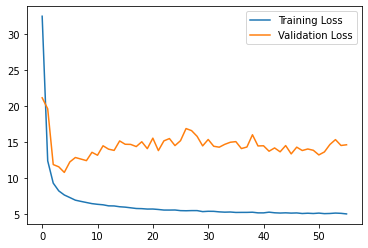

In [185]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [189]:
model.load_state_dict(best["state"])

<All keys matched successfully>

In [164]:
def inference(dataloader, model):
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].permute(0,2,1).to(device)
#             answer = batch["answer"].permute(0,2,1).to(device)
            guess = model(given)
            ts.append(np.array(batch["ts"]))
#             dist.append(torch.abs(given - guess).cpu().numpy())
            dist.append(torch.sum(torch.abs(guess-given), 1).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(64))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [190]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(validloader, model)

CPU times: user 3.37 s, sys: 1.32 s, total: 4.7 s
Wall time: 3.35 s


In [112]:
next(iter(validloader))['answer'].shape

torch.Size([64, 86])

In [191]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [167]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

In [145]:
CHECK_ATT

array([0., 0., 0., ..., 0., 0., 0.])

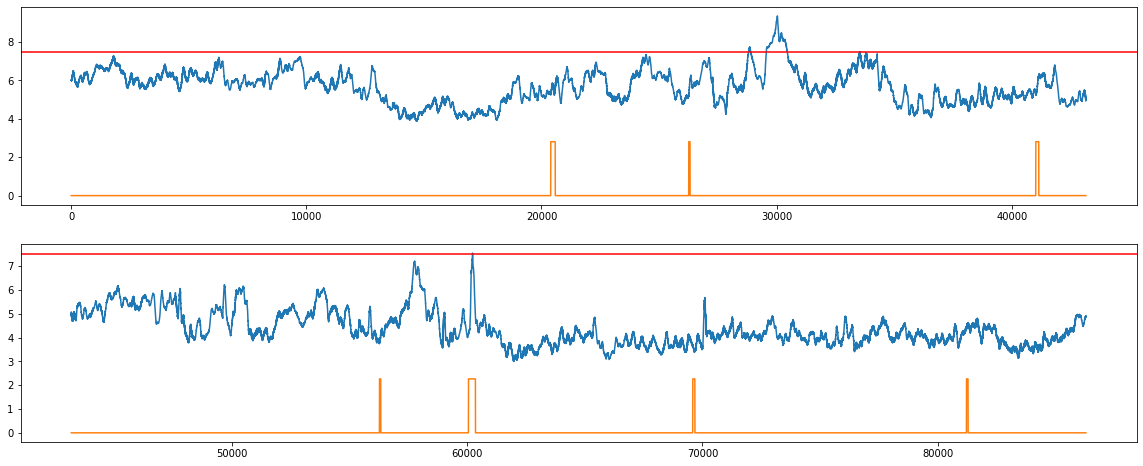

In [195]:
THRESHOLD = 7.5
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)